In [1]:
import cv2 as cv
import numpy as np
import os
import math
import matplotlib.pyplot as plt

# 1.Resizing frames of the video with a desired ratio.

In [2]:
#to resize an image
def resize(img, scale_percent):
#     scale_percent = 400 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
  
    # resize image
    resized = cv.resize(img, dim, interpolation = cv.INTER_AREA)
    return resized

 # 2.Displaying the original video(Press 'q' if you want to quit)

In [3]:
frames = os.listdir(r"D:\Not yours\NU\Master's\2nd semester\Introduction to image processing\Project\Video")

for i in  range(len(frames)):
    img = cv.imread(r"D:\Not yours\NU\Master's\2nd semester\Introduction to image processing\Project\Video\frame" + str(i) + ".jpg")
    img = resize(img, 50)
    cv.imshow("traffic", img)
    key = cv.waitKey(25)
    if key & 0xFF == ord('q'):
        break
cv.destroyAllWindows()

# 3.Let's start detecting cars based on the changes between 2 frames

In [4]:
#reading the first frame
f1 = cv.imread(r"D:\Not yours\NU\Master's\2nd semester\Introduction to image processing\Project\Video\frame" + str(0) + ".jpg")

#defining the resizing factor and resizing the firse frame
resize_factor = 50
f1 = resize(f1, resize_factor)
f1 = cv.cvtColor(f1, cv.COLOR_BGR2GRAY)
    

f2 = cv.imread(r"D:\Not yours\NU\Master's\2nd semester\Introduction to image processing\Project\Video\frame" + str(1) + ".jpg")

#defining the resizing factor and resizing the firse frame
resize_factor = 50
f2 = resize(f2, resize_factor)
f2 = cv.cvtColor(f2, cv.COLOR_BGR2GRAY)

### displaying the first 2 frames.

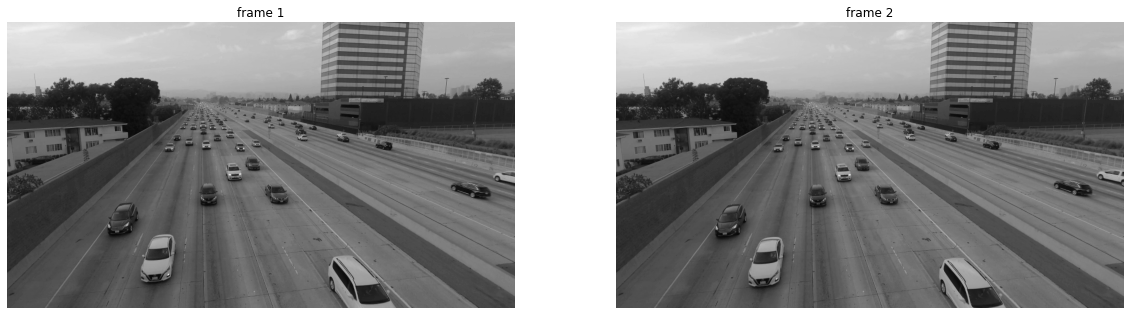

In [8]:
fig = plt.figure(figsize = (20,15))

fig.add_subplot(1, 2, 1)
plt.imshow(f1, cmap = 'gray')
plt.title("frame 1")
plt. axis('off')

fig.add_subplot(1, 2, 2)
plt.imshow(f2, cmap = 'gray')
plt.title("frame 2")
plt. axis('off')

plt.show()

### 3.1 let's see the diff bet. two images

* when we see an object moving in a video, it means that the object is at a different location at every consecutive frame.

* If we assume that apart from that object nothing else moved in a pair of consecutive frames, then the pixel difference of the first frame from the second frame will highlight the pixels of the moving object.

* So, what we can observer from the image is the movement beween the 2 frames.

In [9]:
def image_diff(frame1, frame2):
    #get the diff bet the two frames
    diff = cv.absdiff(frame2, frame1)
    return diff

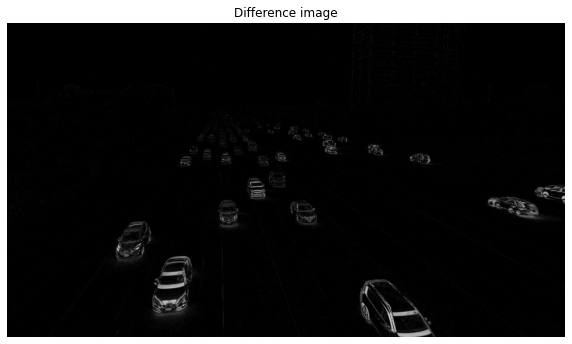

In [12]:
frames_diff = image_diff(f1, f2)
plt.figure(figsize = (10,7))
plt.imshow(frames_diff, cmap = 'gray')
plt.title("Difference image")
plt. axis('off')
plt.show()

### 3.2 thresholding

In this method, the pixel values of a grayscale image are assigned one of the two values:
* Black, 0.
* White,255.

based on a threshold.

In [13]:
def thresholding(diff):
    #thresholding(means that making values of the difference either 0 or 255 based on a threshold)
    _, thresh = cv.threshold(diff, 50, 255, cv.THRESH_BINARY)
    return thresh

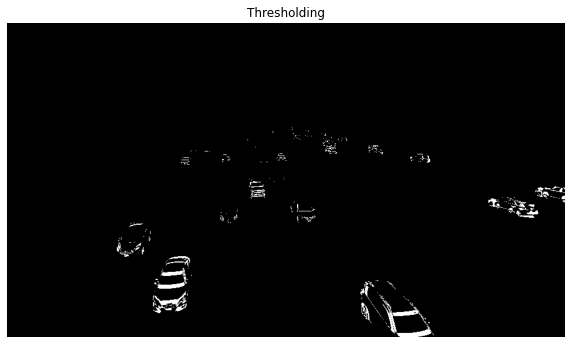

In [15]:
thr = thresholding(frames_diff)
plt.figure(figsize = (10,7))
plt.imshow(thr, cmap = 'gray')
plt.title("Thresholding")
plt. axis('off')
plt.show()

### 3.3 Dilateion

This is a convolution operation on an image wherein a kernel (a matrix) is passed over the entire image.

The idea is to merge the nearby white regions to have fewer contours

        To know more about dilation in a nutshell follow the following links:
        https://www.youtube.com/watch?v=xO3ED27rMHs
        https://docs.opencv.org/4.x/db/df6/tutorial_erosion_dilatation.html

In [17]:
def dilation(thresh):
    #Dilation
    dilation_kernel = np.ones((3,3), np.uint8)
    dilated_img = cv.dilate(thresh, dilation_kernel, iterations = 5)
    return dilated_img

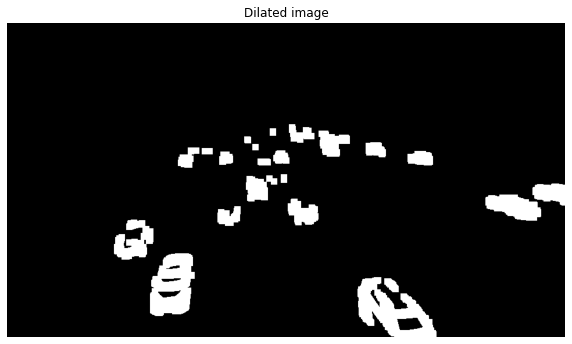

In [18]:
dil = dilation(thr)
plt.figure(figsize = (10,7))
plt.imshow(dil, cmap = 'gray')
plt.title("Dilated image")
plt. axis('off')
plt.show()

### 3.4 Finding contours and build bounding boxes around each contour

In [52]:
def find_contours(dilated_img):
    #find the contours in the image
    #The code below finds all the contours in the entire image and storesb them in the variable ‘contours’.
    contours, _ = cv.findContours(dilated_img, cv.RETR_TREE,cv.CHAIN_APPROX_NONE)
    return contours


def find_bounding_boxes(contours):
    
    detected_rects = [] #list to save the coordinates and dimensions of the detected bounding boxes.
    for cnt in contours:
        x, y, w, h = cv.boundingRect(cnt) #unziping the coordinates and dimensions of the contour.
        
        '''
        the follwing if condition is to just get the boxes in 
        the specific box that the user want the cars to be detected within
        '''
        if x>x1 and y > y1 and x < x1+width and y<y1+height and (cv.contourArea(cnt) >= 700):
            detected_rects.append([x,y,w,h]) 
            
    return detected_rects

def bounding_boxes(contours):
    
    detected_rects = [] #list to save the coordinates and dimensions of the detected bounding boxes.
    for cnt in contours:
        x, y, w, h = cv.boundingRect(cnt) #unziping the coordinates and dimensions of the contour.
        detected_rects.append([x,y,w,h]) 
            
    return detected_rects

In [53]:
cntrs = find_contours(dil)
boxes = bounding_boxes(cntrs)

for  box in boxes:
        x,y,w,h = box
        cv.rectangle(f1, (x,y),(x+w, y+h), (0,255,0),2,  cv.LINE_AA)

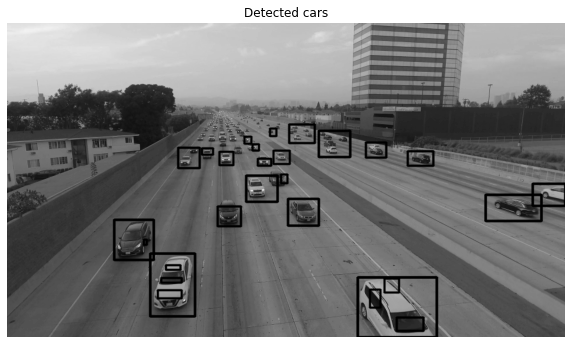

In [54]:
plt.figure(figsize = (10,7))
plt.imshow(f1, cmap = 'gray')
plt.title("Detected cars")
plt. axis('off')
plt.show()

### Now let's combine them all together

In [23]:
def Car_detection(original_1, original_2, resize_factor = 100 ,x1 = 100, y1 = 150, width = 400, height = 100):
    
    #change the frames from RGB to grat scale.
    frame1 = cv.cvtColor(original_1, cv.COLOR_BGR2GRAY)
    frame2 = cv.cvtColor(original_2, cv.COLOR_BGR2GRAY)


    #get the diff bet the two frames
    diff = image_diff(frame1, frame2)

    #thresholding(means that making values of the difference either 0 or 255 based on a threshold)
    thresh = thresholding(diff)
    
   
    #Dilation
    '''
        To know more about dilation in a nutshell follow the following links:
        https://www.youtube.com/watch?v=xO3ED27rMHs
        https://docs.opencv.org/4.x/db/df6/tutorial_erosion_dilatation.html
    '''
    dilated_img = dilation(thresh)
    
    
    #find the contours in the image
    contours = find_contours(dilated_img)
    
    #get the coordinates and dimensions of the detected bounding boxes.
    detected_rects = find_bounding_boxes(contours)
            
    return detected_rects ### *************************************


# Now let's start the tracking part

In [24]:
#A class to present each car or in other word to present the bounding box of the car.
class carTracker:
    '''
    initializing the class to have:
    id_number: to keep tracking the count of the cars.
    center_points: a dictionary to have, for each id of a car, the specific coordinates and dimensions of its bounding box.
    used: a counter to track if the car is not detected for a number of frames to delete its record.
    '''
    def __init__(self):
        self.center_points = {}
        self.id_number = 0
        self.used = {}
        
    
    '''
    a function to add the new cars that has been detected.
    Also to update the position of the cars that was detected before
    and its position has been changed(using the centroid of the detected bounding boxes).
    '''
    def update(self, detected_rects):
        rect_ids = [] #a list to have the dimensions and coordinates of the bounding boxes within the present frame.
        
        #looping on detected cars
        for rect in detected_rects:
            x, y, w, h = rect
            
            #calculating the centroid of the bounding box of each bounding box in the detected ones.
            cent_x = (2*x + w)//2
            cent_y = (2*y + h)//2
            
            the_same_object = False #a flag to announce if the car is a new one or detected before and just moved.
            
            #this loop is to see if the car was detected before or not.
            for id, pt in self.center_points.items():
                #calculating the difference be centroids.
                distance = math.hypot(cent_x - pt[0][0], cent_y - pt[0][1])
                
                
                #the following block is to remove bounding boxes inside othere ones.
                ##################
                # If top-left inner box corner is inside the bounding box
                if pt[1][0] < x and pt[1][1] < y:
                    # If bottom-right inner box corner is inside the bounding box
                    if x + w < pt[1][0] + pt[1][2] and y + h < pt[1][1] + pt[1][3]:
                        the_same_object = True

                if x < pt[1][0] and y < pt[1][1]:
                    # If bottom-right inner box corner is inside the bounding box
                    if pt[1][0] + pt[1][2] < x + w and pt[1][1] + pt[1][3] < y + h:
                        the_same_object = True
                    
                ###################
                
                # check if the distance between centroids is less than a specific number, it is not a new car.
                if distance < 25:
                    the_same_object = True
                    #update the center of the car with the new one
                    self.center_points[id] = [(cent_x, cent_y)]
                    self.center_points[id].append([x, y, w, h, id])
                    self.used[id] = 0 #to state that this car was detected in the most recent frame.
                    rect_ids.append([x, y, w, h, id])
                    break
            
            #this if statement is true if the car was not detected before which means it's a new one
            if the_same_object == False:
                #adding the car to our data with a unique id.
                self.center_points[self.id_number] = [(cent_x, cent_y)]
                self.center_points[self.id_number].append([x, y, w, h, self.id_number])
                self.used[self.id_number] = 0 
                rect_ids.append([x, y, w, h, self.id_number])
                self.id_number += 1
                
        
        '''
        this follwing block is to delete the cars that was not detected for a number of frames also,
        the cars that got out of the box that is specified to detect the cars within 
        '''
        ####################################
        new_center_points = {}
        all_data_within = []
        for obj_id, obj in self.center_points.items():
            #the next if is to check the conditions that specifies if the car is gonna be deleted or not.
            if self.center_points[obj_id][0][1]>500 or self.used[obj_id]>10:
                continue
            
            self.used[obj_id] += 1
            center = self.center_points[obj_id]
            all_data_within.append(center[1])
            new_center_points[obj_id] = center
          
        #update the center points in our class object.
        self.center_points = new_center_points.copy()
        #########################################
        return all_data_within
        

# let's start the magic

In [ ]:
tracker = carTracker() #object of the tracker

#reading the first frame
frame1 = cv.imread(r"D:\Not yours\NU\Master's\2nd semester\Introduction to image processing\Project\Video\frame" + str(0) + ".jpg")

#defining the resizing factor and resizing the firse frame
resize_factor = 50
frame1 = resize(frame1, resize_factor)


w = frame1.shape[1]
h = frame1.shape[0]

#Saving a video
fourcc = cv.VideoWriter_fourcc(*'mp4v') 
video = cv.VideoWriter('video12.avi', fourcc, 6, (w, h))


for i in range(1, len(frames)-1):
    #reading a second frame to compare with, then resizing it
    frame2 = cv.imread(r"D:\Not yours\NU\Master's\2nd semester\Introduction to image processing\Project\Video\frame" + str(i) + ".jpg")
    frame2 = resize(frame2, resize_factor)
    
    #defining the coordinates and dimensions of the square that we want to detect the cars within
    x1 = 200
    y1 = 250
    width = 400
    height = frame2.shape[0] - y1 -100
    
    #calling the car detection fuction with 2 frames
    detected_rects = Car_detection(frame1.copy(), frame2.copy(), 50, x1, y1, width, height)
    
    #calling the update function of our tracker to update the car coorinates and add the new ones.
    rect_ids = tracker.update(detected_rects)
    
    #drawing the bounding boxes our image
    for  rect_id in rect_ids:
        x,y,w,h,id = rect_id
        #checking if the bounding boxes don't exceed a vertical limit
        if y < 400:
            cv.putText(frame1, str(id),(x,y-15), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2)
            cv.rectangle(frame1, (x,y),(x+w, y+h), (0,255,0),2,  cv.LINE_AA)
    
    
    #drawing the box that detects our box that we detect the cars within
    cv.rectangle(frame1, (x1, y1), (x1+width, y1+height), (0, 0, 255), 2, cv.LINE_AA)
    
    #the actual writing of frames in a video.
    video.write(frame1)
    
    cv.imshow("detected cars", frame1)
    key = cv.waitKey(25)
    frame1 = frame2
    if key & 0xFF == ord('q'):
        break
cv.destroyAllWindows()
video.release()




### https://nileuniversity-my.sharepoint.com/:v:/g/personal/mamostafa_nu_edu_eg/ESCPpB8vp4RMlAdHrG7EUigBihNCWRikiW37tVd7cElscw?e=ErdxBf